Plotting some useful results from the triggering experiment

In [144]:
import pandas as pd
import glob
import os
import numpy as np
import datetime
from dateutil import parser
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

In [100]:
#list of files containng the phones we wanted to trigger
to_trigger = glob.glob('Phones_to_trigger*')
#list of files containing the phones we actually did trigger
did_trigger = glob.glob('Devices_triggered*')

In [101]:
#Associate each of the 'to_trigger' files with its associated 'did_trigger'

did_trigger_times = []
for fname in did_trigger:
    trigger_time = fname.split('_')[2]
    did_trigger_times.append(int(trigger_time))

to_trigger_times = []
for fname in to_trigger:
    trigger_time = fname.split('_')[-1].split('.')[0]
    to_trigger_times.append(int(trigger_time))
    
to_trigger_times = np.array(to_trigger_times)
did_trigger_times = np.array(did_trigger_times)

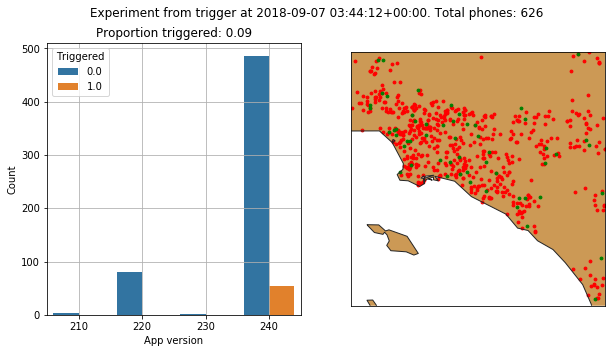

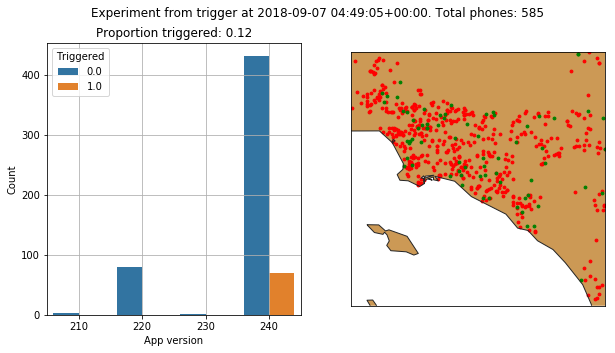

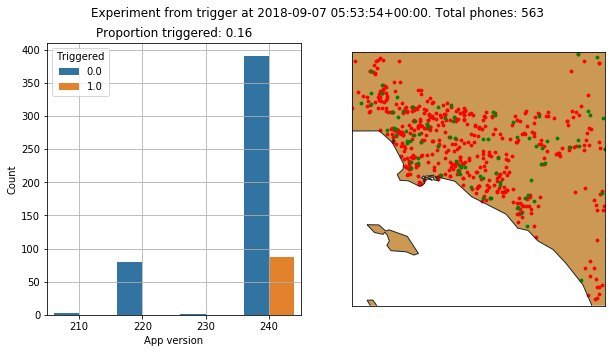

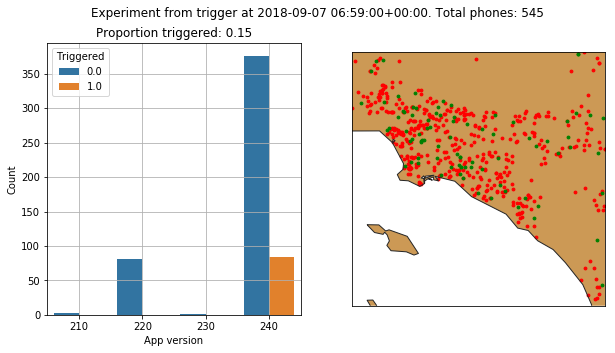

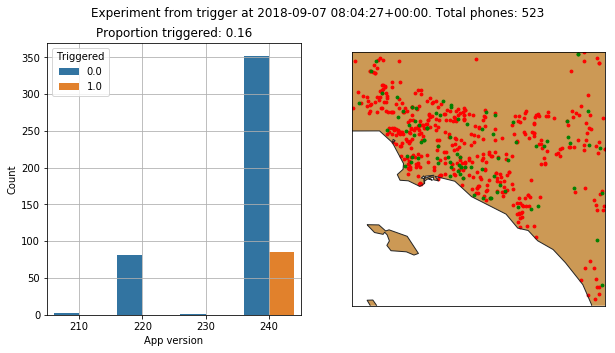

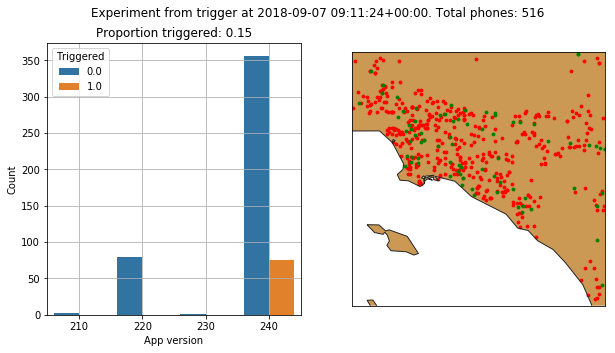

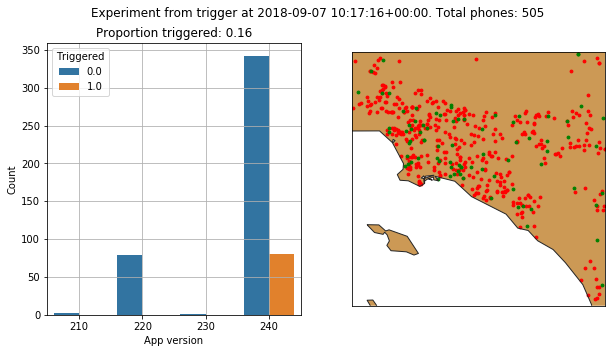

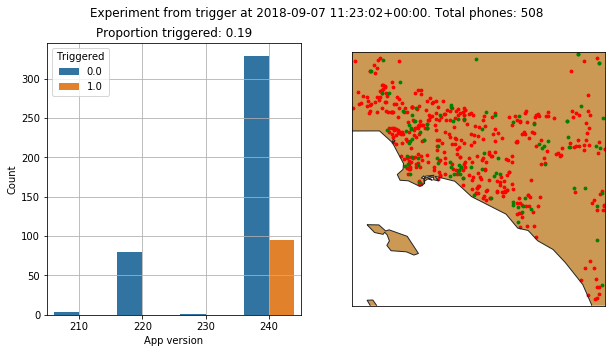

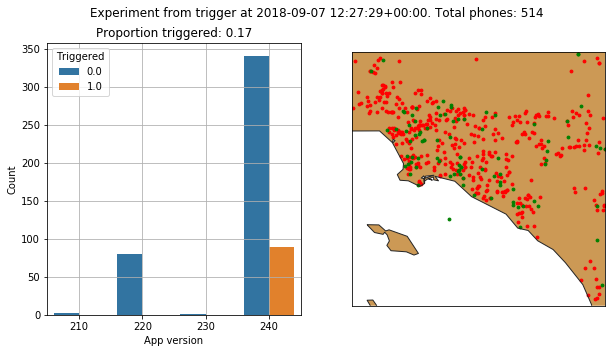

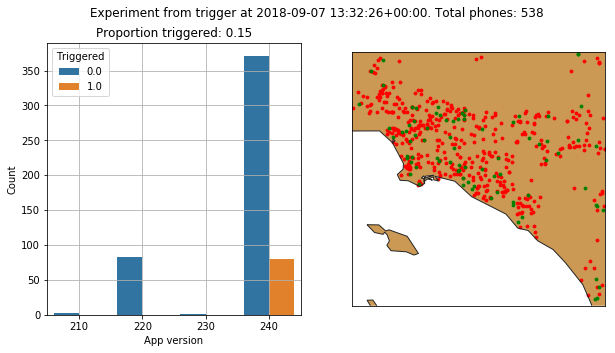

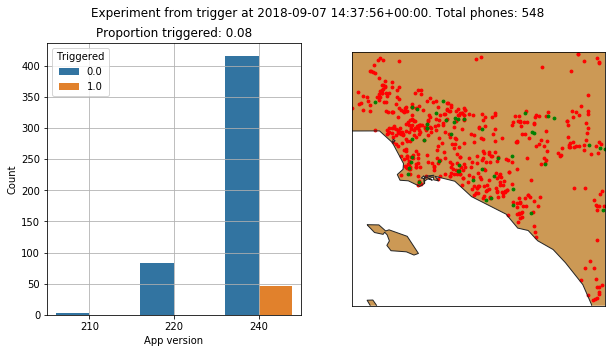

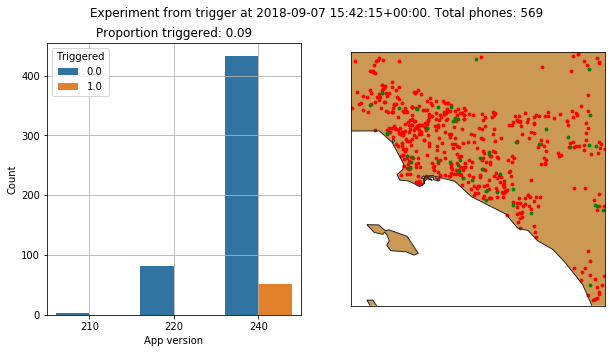

In [210]:
local_tz = pytz.timezone("US/Pacific")
utc_tz = pytz.timezone("utc")
count = 1

for trigger_time in to_trigger_times:
    ind = np.argmin(abs(did_trigger_times-trigger_time))
    
    
    #Convert from unix timestamp and ensure we're in 
    #UTC time
    trigger_time_corr = local_tz.localize(datetime.datetime.fromtimestamp(trigger_time),is_dst=None).astimezone(pytz.utc)
    
    #Convert to utc from PDT (unix timestamp time)    
    #corrected_time = tt + datetime.timedelta(hours=7)
    #print(corrected_time)

    phones_to_trigger = pd.read_csv(to_trigger[ind],index_col=0).reset_index(drop=True)
    phones_did_trigger = pd.read_csv(did_trigger[ind],index_col=0).reset_index(drop=True)
    
    #Get the delay between the time the message was sent and the trigger time 
    
    phones_did_trigger['trigger_delay'] = phones_did_trigger['triggerTimer'].apply(lambda x: 
                  (utc_tz.localize(parser.parse(x),is_dst=None) - trigger_time_corr).total_seconds())
    
    #----------------------------------
    #Create a column that indicates whether or not a phone has been triggered
    
    triggered_ids = phones_did_trigger['deviceId'].values
    all_ids = phones_to_trigger['deviceId'].values
    trigs = np.zeros(len(all_ids))
    
    for i in range(len(all_ids)):
        idval = all_ids[i]
        if idval in triggered_ids:
            trigs[i] = 1
            
    phones_to_trigger['triggered'] = trigs
        
    #----------------------------------
    
    figure = plt.figure(figsize=(10,5))
    ax1 = figure.add_subplot(121)
    proportion_triggered = np.sum(phones_to_trigger['triggered'])/len(phones_to_trigger)
    total_phones = len(phones_to_trigger)
    sns.countplot(x='appVersion',data=phones_to_trigger,hue='triggered',ax=ax1)
    ax1.set_xlabel('App version')
    ax1.set_ylabel('Count')
    ax1.legend(loc='upper left',title='Triggered')
    ax1.grid()
    ax1.set_title('Proportion triggered: %.2f' %proportion_triggered)
    
    ax2 = figure.add_subplot(122)
    
    triggered_phones = phones_to_trigger[phones_to_trigger['triggered']==1]
    untriggered_phones = phones_to_trigger[phones_to_trigger['triggered']==0]

    map = Basemap(llcrnrlon=-118.7, llcrnrlat=33., urcrnrlon=-117.2, urcrnrlat=34.5, lat_0=33.75, lon_0=-118, resolution = 'i',ax=ax2)
    map.fillcontinents(color='#cc9955', lake_color='aqua', zorder = 0)
    map.drawcoastlines(color = '0.15')
    xtrig, ytrig = map(triggered_phones['longitude'].values,triggered_phones['latitude'].values)
    xutrig, yutrig = map(untriggered_phones['longitude'].values,untriggered_phones['latitude'].values)
    map.scatter(xutrig,yutrig,8,marker='o',color='r')
    map.scatter(xtrig,ytrig,8,marker='o',color='g')
    
    figure.suptitle('Experiment from trigger at %s. Total phones: %i' %(trigger_time_corr,total_phones) )
    figname = "Triggering_experiment_%s.png" %count
    plt.savefig(figname,dpi=400) 
    count += 1 
    
    

In [209]:
phones_to_trigger.head()

,ts,deviceId,latitude,longitude,hbSource,appVersion,profileName,profileVersion,hbtime,triggered
0,1536327769368,7835d01e-4ab8-33cb-8493-621b220392e8,34.158977,-118.134865,0,240,default,1526676472034,2018-09-07 13:42:49.368,0.0
1,1536327737732,266964ae-e5f3-3269-98fd-5e94e5f285f7,34.127152,-118.177024,0,240,default,1536327475917,2018-09-07 13:42:17.732,0.0
2,1536327737949,890b9a7e-9dc2-3951-b3de-e19c27feeff1,33.680840,-117.902420,3,240,AsafTest,1526676472034,2018-09-07 13:42:17.949,1.0
3,1536327749449,63e412b9-b7f5-3e8e-b318-cd22ae63d6ea,33.160633,-117.256920,0,240,default,1536327475917,2018-09-07 13:42:29.449,0.0
4,1536327760928,fae6c6e3-856d-34ae-b65b-64bc7f983f29,34.149247,-117.303822,3,240,AsafTest,1526676472034,2018-09-07 13:42:40.928,0.0


In [211]:
phones_did_trigger.head()

,deviceId,triggerTimer,latitude,longitude,accuracy,altitude,triggerFrom,trigger_delay
0,d61ce02b-cb68-3231-b532-5fdbec5ca5a9,2018-09-07 15:46:46.778,33.955684,-117.592063,21.877001,150.699997,6,271.778
1,fb90ae88-b464-38b4-9912-56c1e85b77a8,2018-09-07 15:46:46.878,33.861478,-118.056729,30.628000,0.000000,6,271.878
2,a2170546-fb56-3f44-8e45-7a250b03669e,2018-09-07 15:46:47.033,33.671247,-117.838909,9.648001,-18.596680,6,272.033
3,e2cccb36-2617-3dde-b8c0-d920792377eb,2018-09-07 15:46:47.035,34.259726,-118.518956,11.792000,267.522217,6,272.035
4,1d591041-5472-3efd-901b-063286efaca7,2018-09-07 15:46:47.109,34.167701,-118.417096,9.648001,179.937744,6,272.109
